# Homework 4
CSCI 5636  
Andrew Altomare

Here we implement the four stage third order Bogacki-Shampine explicit Runge-Kutta integrator with adaptive step sizes. The method is tested on the nonlinear Van der Pol equation

$$ 
\begin{align*}
\dot u &= f(u) \\
\begin{bmatrix}\dot u_0 \\ \dot u_1\end{bmatrix} &= \begin{bmatrix} u_1 \\ k(1-u_0^2)u_1 - u_0 \end{bmatrix} 
\end{align*}
$$

Each step of the Bogacki-Shampine method is given by (since $f$ does not depend on $t$):

$$
\begin{align*}
    fY_1 &= f(u_i) \\
    fY_2 &= f(u_i+1/2h_ik_1) \\
    fY_3 &= f(u_i+3/4h_ik_2) \\
    fY_4 &= f(u_i+2/9h_ik_1+1/3h_ik_2+4/9h_ik_3) \\
    u_{i+1} &= u_i+2/9h_ik_1+1/3h_ik_2+4/9h_ik_3 \\
    v_{i+1} &= u_i+7/24h_ik_1+1/4h_ik_2+1/3h_ik_3+1/8h_ik_4
\end{align*}
$$

Of course, a more efficient implementation would take advantage of the First Same As Last property, which is neglected in this implementation for parsimony of code.

In [ ]:
import numpy
import matplotlib.pyplot as plt

def rk_butcher_bs3():
    A = numpy.array([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])
    b = numpy.array([[2/9, 1/3, 4/9, 0],
                     [7/24, 1/4, 1/3, 1/8]])
    return A, b
    
def van_der_pol(u, k=2):
    return numpy.array([u[1], k*(1 - u[0]**2)*u[1] - u[0]], ndmin=1)

### Adaptive step sizes

Below is the integrator, modified from lecture to include a switch for turning on/off adaptive stepping. In each iteration, the local truncation error is computed

$$ e_{\text{loc}}(h) = \lVert h (b - \tilde b)^T f(Y) \rVert $$

If this quantity is greater than the specified `atol` then the step is discarded and `h` is improved with

$$ h\gets 0.9\left(\frac{\epsilon}{e_{\text{loc}}(h)}\right)^{1/3} $$

since the method is third order accurate.

In [212]:
def ode_rkexplicit(f, u0, butcher=None, tfinal=1, h=.1, atol=1e-3, k=2, adaptive=True, linear=False):
    if butcher is None:
        A, b = rk_butcher_bs3()
    else:
        A, b = butcher
    c = numpy.sum(A, axis=1)
    s = len(c)
    u = u0.copy() # third order approximation
    z = u0.copy() # second order approximation
    t = 0
    hist = [(t,u0)]
    errors = [0]
    func_calls = 0
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = numpy.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            if linear == False: # the nonlinear function takes different parameters than the linear mms
                fY[:,i] = f(Yi, k)
            else:
                fY[:,i] = f(0,Yi)
        func_calls += s
        eloc = numpy.linalg.norm( h*(b[0]-b[1]) @ fY.T )
        if adaptive == True:
            if eloc > atol:
                h = 0.9 * (atol / eloc)**(1./3.) * h
            else: # only commit the step if error is acceptably small
                u += h * fY @ b[0]
                # z += h * fY @ b[1] # embedded second order method
                t = tnext
                hist.append((t, u.copy()))
                errors.append(eloc)
        else:
            errors.append(eloc)
            u += h * fY @ b[0]
            t = tnext
            hist.append((t, u.copy()))
    return hist, errors, func_calls

# u0 = numpy.array([.5, 0], ndmin=1)
# hist,_,_ = ode_rkexplicit(van_der_pol, u0, rk_butcher_bs3(), tfinal=4, h=.2, atol=1e-5, k=2, adaptive=True)

### Testing the method on the nonlinear equation

Below we plot the solutions with $k=2,5,20$ at two different scopes. The first row of figures demonstrates the adaptive step sizes getting smaller with time. The second row of figures exhibits the overall periodic shapes in the solution.

<Figure size 432x288 with 0 Axes>

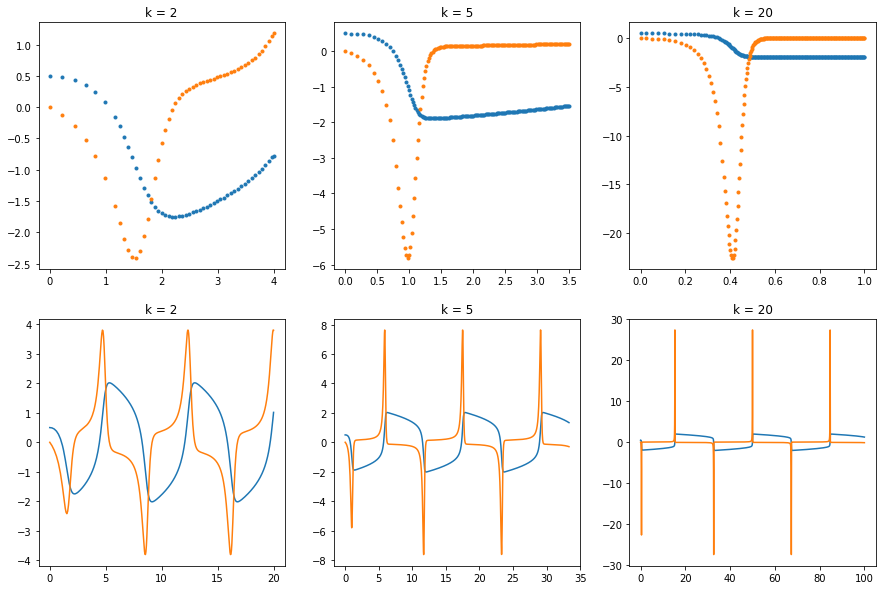

In [209]:
plt.figure();
plt.figure(figsize=(15,10));

u0 = numpy.array([.5, 0], ndmin=1)
for i,k in enumerate([2, 5, 20]):
    hist,_,_ = ode_rkexplicit(van_der_pol, u0, rk_butcher_bs3(), tfinal=(-1./6)*k+(39/9.), h=.8, atol=1e-3, k=k)
    times = [t for t,u in hist]
    plt.subplot(2,3,i+1);
    plt.plot(times, [u for t,u in hist], '.');
    plt.title('k = '+str(k));
    
for i,k in enumerate([2, 5, 20]):
    hist,_,_ = ode_rkexplicit(van_der_pol, u0, rk_butcher_bs3(), tfinal=(40/9.)*k+(100./9), h=k/10., atol=1e-3, k=k)
    times = [t for t,u in hist]
    plt.subplot(2,3,i+4);
    plt.plot(times, [u for t,u in hist], '-');
    plt.title('k = '+str(k));

Modified functions and classes from lecture to help compare adapted step sizes with constant step sizes in terms of accuracy per cost, where cost is determinuted by function calls.

In [208]:
def expm(A):
    """Compute the matrix exponential"""
    L, X = numpy.linalg.eig(A)
    return X @ numpy.diag(numpy.exp(L)) @ numpy.linalg.inv(X)

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A @ u
    def u(self, t, u0):
        t = numpy.array(t, ndmin=1)
        return [numpy.real_if_close(expm(self.A*s) @ u0) for s in t]

test = linear(numpy.array([[0, 1],[-1, 0]]))

def mms_error(h, rk_butcher, adaptive=True, linear=False): # add flag to toggle adaptive step sizes
    if linear == False:
        hist, errors, func_calls = ode_rkexplicit(van_der_pol, u0, rk_butcher(), tfinal=2, 
                                                  h=h, atol=1e-4, k=2, adaptive=adaptive)
    else:
        hist, errors, func_calls = ode_rkexplicit(test.f, u0, rk_butcher(), tfinal=20, 
                                                  h=h, atol=1e-4, k=2, adaptive=adaptive, linear=True)
    times = [t for t,u in hist]
    u = numpy.array([u for t,u in hist])
    if linear == False:
        return numpy.linalg.norm(numpy.array(errors), numpy.inf), func_calls
    else:
        return numpy.linalg.norm(u - test.u(times, u0), numpy.inf), func_calls

### Work-precision diagrams

The first chart compares the two methods on the nonlinear Van der Pol function, which does not have an analytic solution. The analysis thus suffers rigor and uses a history of local error approximations computed at each iteration to comprise a global error estimate. Intuitively though, the graphic makes sense; the number of function calls in the adaptive method will be affected by the tolerance chosen (here fixed at `atol`=$10^{-4}$) more profoundly than it is by the initial time step $h_0$.

<Figure size 432x288 with 0 Axes>

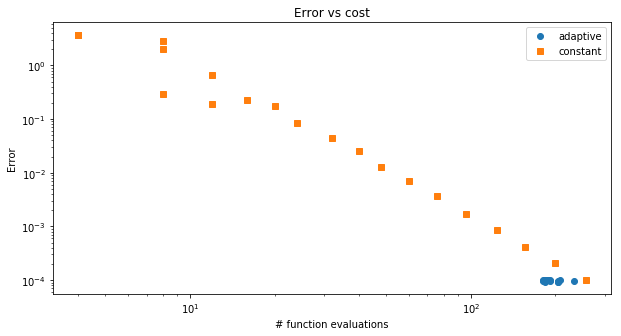

In [207]:
hs = numpy.logspace(-1.5, .5, 20)
result_adaptive = [mms_error(h, rk_butcher_bs3, adaptive=True) for h in hs]
result_constant = [mms_error(h, rk_butcher_bs3, adaptive=False) for h in hs]
func_calls_adaptive = [x[1] for x in result_adaptive]
func_calls_constant = [x[1] for x in result_constant]
error_adaptive = [x[0] for x in result_adaptive]
error_constant = [x[0] for x in result_constant]

plt.figure()
plt.figure(figsize=(10,5));

plt.loglog(func_calls_adaptive, error_adaptive, 'o', label='adaptive')
plt.loglog(func_calls_constant, error_constant, 's', label='constant')
plt.title('Error vs cost')
plt.ylabel('Error')
plt.xlabel('# function evaluations')
plt.legend(loc='upper right');

Below we perform a more rigorous test of error vs cost using a linear manufactured solution. But we see similar behavior.

<Figure size 432x288 with 0 Axes>

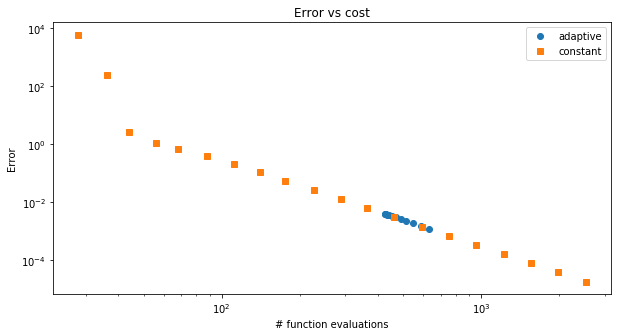

In [206]:
result_adaptive = [mms_error(h, rk_butcher_bs3, adaptive=True, linear=True) for h in hs]
result_constant = [mms_error(h, rk_butcher_bs3, adaptive=False, linear=True) for h in hs]
func_calls_adaptive = [x[1] for x in result_adaptive]
func_calls_constant = [x[1] for x in result_constant]
error_adaptive = [x[0] for x in result_adaptive]
error_constant = [x[0] for x in result_constant]

plt.figure();
plt.figure(figsize=(10,5));

plt.loglog(func_calls_adaptive, error_adaptive, 'o', label='adaptive');
plt.loglog(func_calls_constant, error_constant, 's', label='constant');
plt.title('Error vs cost');
plt.ylabel('Error');
plt.xlabel('# function evaluations');
plt.legend(loc='upper right');

### Conclusions

In terms of pure efficiency, these methods seem fairly comparable. Whether one is preferable would depend on what the user values. If some threshold of error tolerance is known a priori then the adaptive method would be a more natural choice. But if instead function calls are very expensive and computing resources pose a significant bottleneck, and the user is willing to take the best accuracy they can get for the amount of computing resources they can afford then the constant step size method would provide an option where the number of function calls is more predictable.

After running a variety of configurations it is also apparent that the adaptive step size method is much more reliable. Especially with coarse dicretizations, the constant step size method can yield massive errors; allowing for a tolerance tempers the error regardless of initial step size, which is a nice assurance.